In [1]:
import os
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
import math
import random
import time
import json
from data_process        import *
from model               import *

BATCH_SIZE     = 10
TIME_STEP      = 10
LR             = 0.001
EPOCH_UP       = 50
EPOCH_LOW      = 30
INPUT_HEIGHT   = 64
INPUT_WIDTH    = 64
INPUT_CH       = 1
OUTPUT_HEIGHT  = INPUT_HEIGHT
OUTPUT_WIDTH   = INPUT_WIDTH
OUTPUT_CH      = INPUT_CH
Mem_size       = 16
encoder_channel = [32, 32, 32] 
seq_enc_channel = [16]
seq_dec_channel = [64, 64] 
decoder_channel = [32, 32, 32] 
"""
ENCODER_ARCH   = {'l0':{'type':'input', 'neurons':INPUT_HEIGHT*INPUT_WIDTH*INPUT_CH, 
                        'shape':[BATCH_SIZE, INPUT_HEIGHT, INPUT_WIDTH, INPUT_CH]},
                  'l1':{'type':'ConvLSTM', 'filter':[5, 5, INPUT_CH, 128], 'stride':[1, 1, 1, 1], 
                        'shape':[BATCH_SIZE, INPUT_HEIGHT, INPUT_WIDTH, 128]},
                 }
DECODER_ARCH   = {'l0':{'type':'input', 'shape':[BATCH_SIZE, INPUT_HEIGHT, INPUT_WIDTH, INPUT_CH]},
                  'l1':{'type':'LSTM', 'filter':[5, 5, INPUT_CH, 128], 'stride':[1, 1, 1, 1], 
                        'shape':[BATCH_SIZE, INPUT_HEIGHT, INPUT_WIDTH, 128]},
                  'l2':{'type':'output', 'neurons':OUTPUT_HEIGHT*OUTPUT_WIDTH*OUTPUT_CH, 
                        'filter':[5, 5, 128, INPUT_CH], 'stride':[1, 1, 1, 1], 
                        'shape':[BATCH_SIZE, OUTPUT_HEIGHT, OUTPUT_WIDTH, OUTPUT_CH]}}
"""

"\nENCODER_ARCH   = {'l0':{'type':'input', 'neurons':INPUT_HEIGHT*INPUT_WIDTH*INPUT_CH, \n                        'shape':[BATCH_SIZE, INPUT_HEIGHT, INPUT_WIDTH, INPUT_CH]},\n                  'l1':{'type':'ConvLSTM', 'filter':[5, 5, INPUT_CH, 128], 'stride':[1, 1, 1, 1], \n                        'shape':[BATCH_SIZE, INPUT_HEIGHT, INPUT_WIDTH, 128]},\n                 }\nDECODER_ARCH   = {'l0':{'type':'input', 'shape':[BATCH_SIZE, INPUT_HEIGHT, INPUT_WIDTH, INPUT_CH]},\n                  'l1':{'type':'LSTM', 'filter':[5, 5, INPUT_CH, 128], 'stride':[1, 1, 1, 1], \n                        'shape':[BATCH_SIZE, INPUT_HEIGHT, INPUT_WIDTH, 128]},\n                  'l2':{'type':'output', 'neurons':OUTPUT_HEIGHT*OUTPUT_WIDTH*OUTPUT_CH, \n                        'filter':[5, 5, 128, INPUT_CH], 'stride':[1, 1, 1, 1], \n                        'shape':[BATCH_SIZE, OUTPUT_HEIGHT, OUTPUT_WIDTH, OUTPUT_CH]}}\n"

In [2]:
#model = MovingMNISTModel(encode_arch=ENCODER_ARCH, decode_arch=DECODER_ARCH, input_height=INPUT_HEIGHT, input_width=INPUT_WIDTH, 
#                         input_ch=INPUT_CH, output_height=OUTPUT_HEIGHT, output_width=OUTPUT_WIDTH, output_ch=OUTPUT_CH, 
#                         batch_size=BATCH_SIZE, LR=LR, tensor=False)
model = MovingMNISTConvLSTM(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CH, TIME_STEP, BATCH_SIZE, encoder_channel, seq_enc_channel, 
                            seq_dec_channel, decoder_channel, LR)
init  = tf.global_variables_initializer()
sess  = tf.Session()
sess.run(init)

In [3]:
# train, valid, test: [20, DATA_SIZE, 16, 16, 16]
train, valid, test = get_data("./Dataset/train_20.npz", "./Dataset/valid_20.npz", "./Dataset/test_20.npz")
print "Get data done!"

Get data done!


In [4]:
LOSS_TRAIN = []
LOSS_VALID = [np.inf]
total_loss = 0
ep_idx = 1
#break_flag = False
while True:
    train = np.take(train, np.random.rand(train.shape[1]).argsort(), axis=1, out=train)
    # training
    for idx in xrange(10000/BATCH_SIZE):
        start = time.time()
        sequence = train[0:10, idx*BATCH_SIZE:(idx+1)*BATCH_SIZE, :, :, :]
        predict  = train[10:20, idx*BATCH_SIZE:(idx+1)*BATCH_SIZE, :, :, :]
        feed_dict = {model.x: sequence, model.y: predict, model.training:True}
        _, loss = sess.run([model.train_op, model.pred_loss], feed_dict)
        LOSS_TRAIN.append(loss)
        end = time.time()
        # result
        print "mini-batch:", idx, "    mini-batch loss:", LOSS_TRAIN[-1], "    time:", end-start
    
    #if break_flag == False:
    #    ep_idx+=1
    #else:
    #    break
    
    start = time.time()
    # validation
    for idx in xrange(2000/BATCH_SIZE):
        sequence = train[0:10, idx*BATCH_SIZE:(idx+1)*BATCH_SIZE, :, :]
        predict  = train[10:20, idx*BATCH_SIZE:(idx+1)*BATCH_SIZE, :, :]
        feed_dict = {model.x: sequence, model.y: predict, model.training:False}
        loss = sess.run(model.pred_loss, feed_dict)
        total_loss = total_loss + loss
    end = time.time()
    # result
    LOSS_VALID.append(total_loss/(2000/BATCH_SIZE))
    print "Batch:", ep_idx, "    Valid loss:", LOSS_VALID[-1], "    time:", end-start
    ep_idx += 1
    if LOSS_VALID[-2] - LOSS_VALID[-1] < 0: #or ep_idx >= 3:
        break
    else:
        total_loss = 0
    

mini-batch: 0     mini-batch loss: 2866.07     time: 3.16095018387
mini-batch: 1     mini-batch loss: 1825.91     time: 1.75027799606
mini-batch: 2     mini-batch loss: 1234.86     time: 1.74964118004
mini-batch: 3     mini-batch loss: 952.195     time: 1.74897098541
mini-batch: 4     mini-batch loss: 900.402     time: 1.74891901016
mini-batch: 5     mini-batch loss: 875.06     time: 1.74896097183
mini-batch: 6     mini-batch loss: 803.303     time: 1.74941396713
mini-batch: 7     mini-batch loss: 873.293     time: 1.74899697304
mini-batch: 8     mini-batch loss: 848.296     time: 1.74937295914
mini-batch: 9     mini-batch loss: 885.939     time: 1.75003814697
mini-batch: 10     mini-batch loss: 778.044     time: 1.74949407578
mini-batch: 11     mini-batch loss: 768.317     time: 1.74873280525
mini-batch: 12     mini-batch loss: 788.616     time: 1.74846100807
mini-batch: 13     mini-batch loss: 818.119     time: 1.75121712685
mini-batch: 14     mini-batch loss: 790.911     time: 1.749

In [5]:
saver = tf.train.Saver()
save_path = saver.save(sess, "./Models/ConvLSTM_16"+".ckpt")
LOSS_TRAIN = np.asarray(LOSS_TRAIN)
LOSS_VALID = np.asarray(LOSS_VALID)
np.savetxt("./LearningCurve/ConvLSTM_16_train.csv", LOSS_TRAIN, delimiter=",")
np.savetxt("./LearningCurve/ConvLSTM_16_valid.csv", LOSS_VALID, delimiter=",")

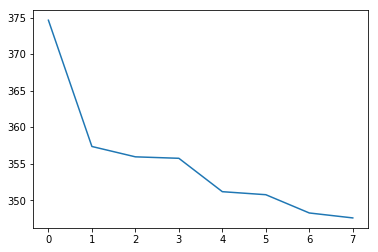

374.632224426
357.35561676
355.939032745
355.738694458
351.169077606
350.755546112
348.255987396
347.579142303
349.579129028


In [6]:
%matplotlib inline
fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)

ax.plot(LOSS_VALID[1:-1])
plt.ion()
plt.show()

for ep in range(1, len(LOSS_VALID)):
    print LOSS_VALID[ep]

In [7]:
LOSS_TEST = []
total_loss = 0
pred_list = []
# training
for idx in xrange(3000/BATCH_SIZE):
    sequence = test[0:10, idx*BATCH_SIZE:(idx+1)*BATCH_SIZE, :, :, :]
    predict  = test[10:20, idx*BATCH_SIZE:(idx+1)*BATCH_SIZE, :, :, :]
    feed_dict = {model.x: sequence, model.y: predict, model.training:False}
    pred, loss = sess.run([model.pred, model.pred_loss], feed_dict)
    total_loss = total_loss + loss
    pred_list.append(pred)
LOSS_TEST.append(total_loss/(3000/BATCH_SIZE))

# print current loss
print "Test Loss:", LOSS_TEST[-1]

Test Loss: 347.145492859


In [8]:
total_pred = np.asarray(pred_list)
total_pred = np.reshape(np.transpose(np.squeeze(total_pred), (1, 0, 2, 3, 4)), (20, 3000, 64, 64))
np.savez("./Predict/ConvLSTM_16_mm.npz", total_pred)

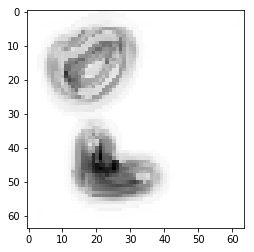

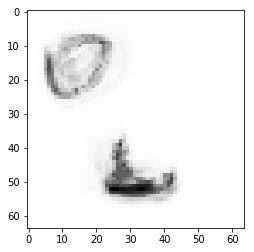

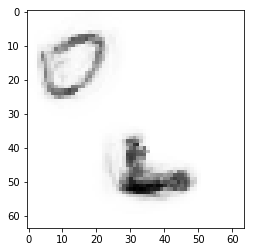

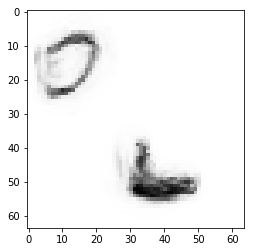

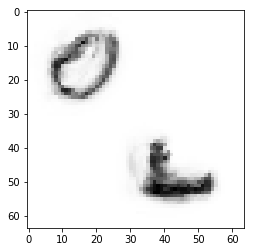

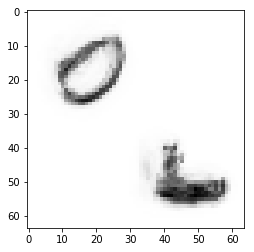

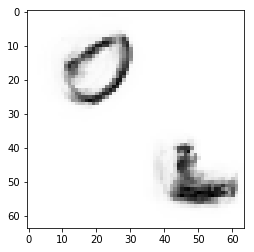

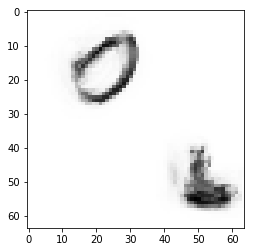

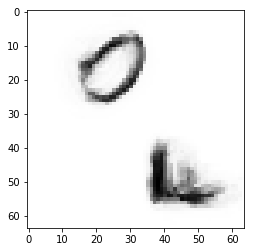

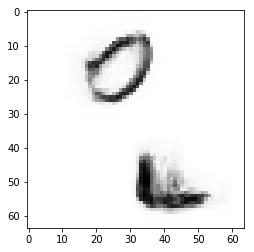

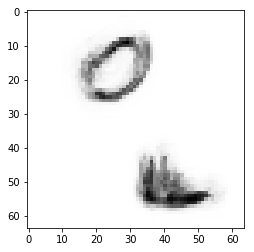

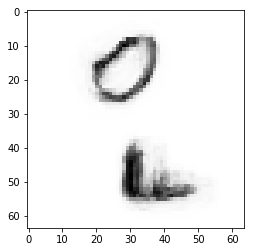

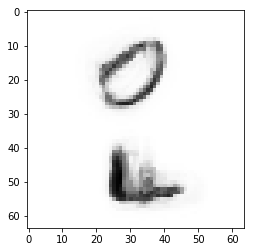

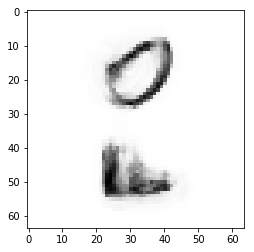

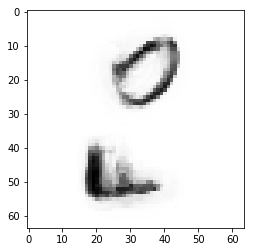

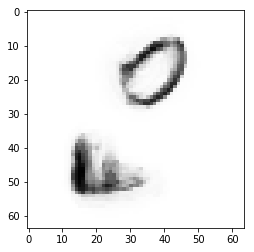

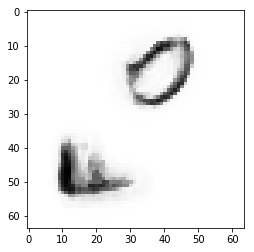

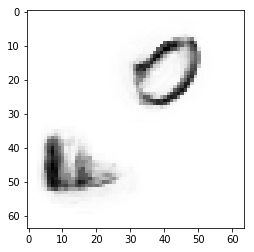

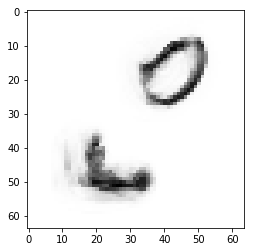

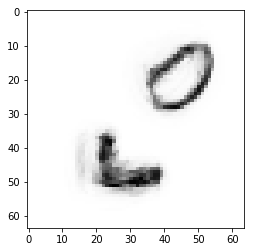

In [11]:
%matplotlib inline

for idx in xrange(20):
    fig = plt.figure()
    ax  = fig.add_subplot(1, 1, 1)
    plt.ion()
    plt.imshow(total_pred[idx, 0, :, :], cmap='Greys')

In [10]:
np.savetxt("./Predict/ConvLSTM_16_mm.csv", np.reshape(total_pred[:, 0, :, :], (-1, 4096)), delimiter=",")
np.savetxt("./Predict/ConvLSTM_16_mm_Truth.csv", np.reshape(test[:, 0, :, :, 0], (-1, 4096)), delimiter=",")